# ToO Secondary Targeting

In [81]:
import os
from astropy.io import ascii, fits
from astropy.table import join, hstack, vstack, unique, Table
from desispec.spectra import stack as specstack
from desispec.coaddition import coadd_cameras
from desispec.io import read_spectra, write_spectra

import psycopg2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=16)
mpl.rc('axes', titlesize='small')

## Postgres Query

In [9]:
# Change use_cached = False if we want to redo the query at some point.
use_cached = False

if os.path.exists('too_targets.fits') and use_cached:
    tf_targets = Table.read('too_targets.fits')
else:
    try:
        db = psycopg2.connect(host='decatdb.lbl.gov', database='desi', user='desi')
        cursor = db.cursor()
        
        query = """SELECT DISTINCT mtl.targetid, mtl.tooid, mtl.program, fd.target_ra, fd.target_dec, fd.tileid, fd.petal_loc, zd.z, zd.zerr, zd.spectype, zd.deltachi2, zd.zwarn, zd.yyyymmdd
                   FROM mtl
                   INNER JOIN
                       fibermap_daily fd ON mtl.targetid = fd.targetid
                   INNER JOIN
                       zbest_daily zd on zd.targetid = fd.targetid
                   WHERE (mtl.program LIKE 'ToO');
                """

#         query = """SELECT DISTINCT pr.pvtype, pr.sga_id, fd.targetid, fd.target_ra, fd.target_dec, zd.z, zd.zerr, zd.spectype, zd.deltachi2, zd.zwarn, zd.yyyymmdd
#                     FROM fibermap_daily fd
#                     INNER JOIN
#                         zbest_daily zd ON zd.targetid = fd.targetid
#                     INNER JOIN
#                         (SELECT targetid, MAX(expid) AS max_expid
#                             FROM fibermap_daily
#                             GROUP BY targetid) groupfmap
#                             ON fd.targetid = groupfmap.targetid AND fd.expid = groupfmap.max_expid
#                     INNER JOIN
#                         (SELECT targetid, MAX(yyyymmdd) AS max_date
#                             FROM zbest_daily
#                             GROUP BY targetid) groupzd
#                             ON zd.targetid = groupzd.targetid AND zd.yyyymmdd = groupzd.max_date
#                     INNER JOIN pv.proposals pr ON (CAST(pr.ra*10000 AS INTEGER) = CAST(fd.target_ra*10000 AS INTEGER)) AND
#                                                   (CAST(pr.dec*10000 AS INTEGER) = CAST(fd.target_dec*10000 AS INTEGER))
#                     WHERE (pr.pvtype LIKE 'TFT' or pr.pvtype LIKE 'EXT' or pr.pvtype LIKE 'SGA')
#                     ORDER BY zd.yyyymmdd;"""

        cursor.execute(query)
        rows = cursor.fetchall()
        too_targets = Table(list(map(list, zip(*rows))),
                            names=['TARGETID', 'TOOID', 'PROGRAM', 'TARGET_RA', 'TARGET_DEC', 'TILE', 'PETAL', 'Z', 'ZERR', 'SPECTYPE', 'DELTACHI2', 'ZWARN', 'YYYYMMDD'])
        too_targets.write('too_targets.fits', overwrite=True)
        
    except (Exception, psycopg2.Exception) as error:
        print(error)
    finally:
        if db is not None:
            db.close()
            
too_targets

TARGETID,TOOID,PROGRAM,TARGET_RA,TARGET_DEC,TILE,PETAL,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,YYYYMMDD
int64,int64,str3,float64,float64,int64,int64,float64,float64,str6,float64,int64,int64
43977408033849634,592950015,ToO,216.1834,-2.0112,233,0,-0.00199570145091582,4.13115987161332e-48,STAR,1.94266889222573e+84,1570,20210504
43977408033849634,592950015,ToO,216.1834,-2.0112,233,0,0.872109180759721,0.000121906578348338,GALAXY,0.471144869923592,4,20210505
43977408033849634,592950015,ToO,216.1834,-2.0112,234,0,-0.00199570145091582,4.13115987161332e-48,STAR,1.94266889222573e+84,1570,20210504
43977408033849634,592950015,ToO,216.1834,-2.0112,234,0,0.872109180759721,0.000121906578348338,GALAXY,0.471144869923592,4,20210505
43977408096764091,593100257,ToO,219.9883,-1.9706,261,0,1.22201161601295,0.000153658036622211,GALAXY,16.744353055954,0,20210430
43977408096764276,593100038,ToO,219.9883,-1.9706,254,0,0.766372279716038,0.000100062139685704,GALAXY,2.29361455887556,4,20210504
43977408096764276,593100038,ToO,219.9883,-1.9706,254,0,1.09334199560186,6.47886012075962e-05,GALAXY,4.59592429297936,4,20210505
43977408096764276,593100038,ToO,219.9883,-1.9706,254,0,1.15918013215847,0.000103435487562196,GALAXY,6.8452275916934,4,20210508
43977408096764276,593100038,ToO,219.9883,-1.9706,254,0,1.49009496463586,5.55352435591618e-05,GALAXY,9.56093067117035,0,20210503


In [11]:
np.unique(too_targets['TARGETID'])

43977408033849634
43977408096764091
43977408096764276
43977414014927254
43977414082035733
43977414086230372
43977420159582429
43977420159582576
43977420163776665
43977426203574529
43977426228740203


In [30]:
targids = np.unique(too_targets['TARGETID'][(too_targets['Z'] > 0.36) & (too_targets['Z'] < 0.38)])
for targid in targids:
    tab = too_targets['TARGETID', 'TILE', 'PETAL', 'Z', 'SPECTYPE', 'ZWARN', 'DELTACHI2', 'YYYYMMDD'][too_targets['TARGETID'] == targid]
    tab.sort('YYYYMMDD')
    print(tab)

     TARGETID     TILE PETAL ... ZWARN    DELTACHI2     YYYYMMDD
----------------- ---- ----- ... ----- ---------------- --------
43977491479527890   10     1 ...     0 131.840702995658 20210503
43977491479527890   10     1 ...     0 811.846173107624 20210503
43977491479527890   11     1 ...     0 131.840702995658 20210503
43977491479527890   11     1 ...     0 811.846173107624 20210503
43977491479527890   21     1 ...     0 131.840702995658 20210503
43977491479527890   21     1 ...     0 811.846173107624 20210503
43977491479527890   10     1 ...     0 1201.09257364273 20210505
43977491479527890   11     1 ...     0 1201.09257364273 20210505
43977491479527890   21     1 ...     0 1201.09257364273 20210505
     TARGETID     TILE PETAL ... ZWARN    DELTACHI2     YYYYMMDD
----------------- ---- ----- ... ----- ---------------- --------
43977491487916548   10     9 ...     0 654.379524588585 20210430
43977491487916548  442     0 ...     0 654.379524588585 20210430
43977491487916548   20   

In [33]:
np.any(too_targets['TARGETID'] == 39627793817928042)

False

## Load ToO Target SQLite DB

In [11]:
import sqlite3
from contextlib import closing

In [12]:
query = "SELECT DISTINCT mtl.targetid, f.target_ra, f.target_dec, f.yyyymmdd, f.tile, f.petal \
         FROM mtl INNER JOIN fibermap_daily AS f \
         ON mtl.targetid==f.targetid \
         WHERE mtl.program='ToO';"

# query = 'SELECT m.PROGRAM, m.TARGETID, m.RA, m.DEC, s.NIGHT, s.EXPID, s.TILEID, s.FIBER, s.PETAL_LOC \
#                    FROM mtl as m \
#                    JOIN spectra as s on S.TARGETID = m.TARGETID \
#                    ORDER BY m.TARGETID ASC, s.NIGHT;'

with closing(sqlite3.connect('/global/cfs/cdirs/desi/science/td/db/desi.db')) as db:
    with closing(db.cursor()) as cursor:
        rows = cursor.execute(query).fetchall()

In [16]:
too_targets = Table(list(map(list, zip(*rows))),
#                     names=['PROGRAM', 'TARGETID', 'TARGET_RA', 'TARGET_DEC', 'DATE', 'EXPID', 'TILEID', 'FIBER', 'PETAL'])
                    names=['TARGETID', 'TARGET_RA', 'TARGET_DEC', 'DATE', 'TILEID', 'PETAL'])
too_targets['PROGRAM'] = 'ToO'
too_targets

TARGETID,TARGET_RA,TARGET_DEC,DATE,TILEID,PETAL,PROGRAM
int64,float64,float64,int64,int64,int64,str3
43977450371153935,219.698146,-0.134828,20210503,262,5,ToO
43977450371153935,219.698146,-0.134828,20210502,262,5,ToO
43977456419340308,220.147675,0.051003,20210503,262,6,ToO
43977456419340308,220.147675,0.051003,20210502,262,6,ToO
43977414082035733,216.688787,-1.861117,20210503,225,0,ToO
43977516771180576,217.259658,2.561925,20210430,287,3,ToO
43977432176263222,215.01975,-1.029686,20210503,232,2,ToO
43977444352327746,220.7983,-0.4306,20210503,262,7,ToO
43977444352327746,220.7983,-0.4306,20210502,262,7,ToO


In [17]:
def plot_radec(table):
    """Mollweide projection plot adapted to astro coordinates.
    
    Parameters
    ----------
    table : astropy.table.Table
        Data table with secondary target info.
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object to let user apply further plot manipulation.
    """
    fig, ax = plt.subplots(1,1, figsize=(8,4), subplot_kw={'projection': 'mollweide'})
    
    # Loop through unique classes.
    class_names = np.unique(table['PROGRAM'])
    for class_name in class_names:
        select = table['PROGRAM'] == class_name
        
        # Convert RA, Dec to radians.
        # Rotate the RA so that the plot goes 360->0 left to right.
        _ra = np.radians(180. - table[select]['TARGET_RA'])
        _dec = np.radians(table[select]['TARGET_DEC'])
        ax.scatter(_ra, _dec, alpha=0.5, s=5, label=class_name)

    # Clean up the plot and return the Figure object.
    ax.set(xticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
           xticklabels=['22h', '20h', '18h', '16h', '14h', '12h', '10h', '8h', '6h', '4h', '2h'])
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(ls=':')
    
    ax.legend(fontsize=8, loc='lower right')
    fig.tight_layout()

    return fig;

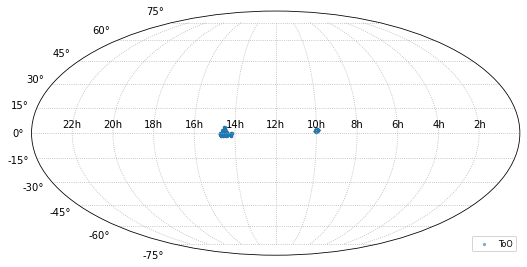

In [18]:
fig = plot_radec(too_targets)

## Extract Object Redshifts

For each object in the table, extract the redshift.

In [43]:
tile_date_petal = np.asarray([[39627793817928042, 56 , 20210407 ,         3],
                              [39627793817928042, 67 , 20210407 ,         3],
                              [39627793817928042, 72 , 20210504 ,         3],
                              [39627793817928042, 73 , 20210505 ,         3],
                              [39627793817928042, 65 , 20210512 ,         3]])

# for too_target in too_targets:
#     tdp = [too_target[_] for _ in ['TILEID', 'DATE', 'PETAL']]
#     if tdp in tile_date_petal:
#         continue
#     tile_date_petal.append(tdp)

tile_date_petal = Table(tile_date_petal, names=['TARGETID', 'TILEID', 'DATE', 'PETAL'])
tile_date_petal

TARGETID,TILEID,DATE,PETAL
int64,int64,int64,int64
39627793817928042,56,20210407,3
39627793817928042,67,20210407,3
39627793817928042,72,20210504,3
39627793817928042,73,20210505,3
39627793817928042,65,20210512,3


In [61]:
redux = 'everest'

toospec = None

n = 0

for i, (targetids, tile, date, petal) in enumerate(tile_date_petal):
#     select = (too_targets['TILEID']==tile) & (too_targets['DATE']==date) & (too_targets['PETAL']==petal)
#     n += np.sum(select)
#     targetids = too_targets[select]['TARGETID']
    
    folder = '{}/{}/tiles/pernight/{}/{}'.format(os.environ['DESI_SPECTRO_REDUX'], redux, tile, date)
    cdfile = '{}/coadd-{}-{}-{}.fits'.format(folder, petal, tile, date)
    zbfile = '{}/redrock-{}-{}-{}.fits'.format(folder, petal, tile, date)
    print(cdfile)
    
    if os.path.exists(zbfile) and os.path.exists(cdfile):
        spectra = read_spectra(cdfile)
        
        # Select matching target IDs from the ToO list and read out ToO spectra.
        sselect = np.in1d(spectra.fibermap['TARGETID'], targetids)
        spectra = spectra[sselect]
        if not hasattr(spectra, 'scores_comments'):
            spectra.scores_comments = None
        
        # Select matching target IDs from the ToO list and access the redshift fit.
        zbest = fits.open(zbfile)['REDSHIFTS'].data
        zselect = np.in1d(zbest['TARGETID'], targetids)
        zbest = zbest[zselect]
        
        # Append spectra to a larger list of spectra, stored in memory.
        # Note that an EXPID is required in the update step below, but the coadded spectra
        # have a FIRST_EXPID and a LAST_EXPID. So copy one of these as a hack.
#         spectra.fibermap['EXPID'] = spectra.fibermap['LAST_EXPID']
        spectra.extra_catalog = zbest
        
        if toospec is None:
            toospec = spectra
        else:
            toospec = specstack([toospec, spectra])
        
        if (i+1) % 10 == 0:
            print('{} out of {}; ({} {})'.format(i+1, len(tile_date_petal), n, toospec.num_spectra()))
            
if not hasattr(toospec, 'scores_comments'):
    toospec.scores_comments = None

/global/cfs/cdirs/desi/spectro/redux/everest/tiles/pernight/56/20210407/coadd-3-56-20210407.fits
INFO:spectra.py:282:read_spectra: iotime 0.466 sec to read coadd-3-56-20210407.fits at 2021-08-27T10:53:42.751850
/global/cfs/cdirs/desi/spectro/redux/everest/tiles/pernight/67/20210407/coadd-3-67-20210407.fits
INFO:spectra.py:282:read_spectra: iotime 0.633 sec to read coadd-3-67-20210407.fits at 2021-08-27T10:53:43.861829
/global/cfs/cdirs/desi/spectro/redux/everest/tiles/pernight/72/20210504/coadd-3-72-20210504.fits
INFO:spectra.py:282:read_spectra: iotime 0.597 sec to read coadd-3-72-20210504.fits at 2021-08-27T10:53:45.080245
/global/cfs/cdirs/desi/spectro/redux/everest/tiles/pernight/73/20210505/coadd-3-73-20210505.fits
INFO:spectra.py:282:read_spectra: iotime 0.615 sec to read coadd-3-73-20210505.fits at 2021-08-27T10:53:46.235028
/global/cfs/cdirs/desi/spectro/redux/everest/tiles/pernight/65/20210512/coadd-3-65-20210512.fits
INFO:spectra.py:282:read_spectra: iotime 0.601 sec to read 

In [62]:
toospec.num_spectra()

5

### Output Redrock Spectral Types

In [63]:
types_, counts_ = np.unique(toospec.extra_catalog['SPECTYPE'], return_counts=True)
for t, c in zip(types_, counts_):
    print('{:10s} : {:10d} ({:.1f}%)'.format(t, c, 100*c/len(toospec.extra_catalog)))

b'GALAXY'  :          5 (100.0%)


## Write Output

### FITS Format

This format is needed to preserve the redrock template coefficients in the output, should they be needed for spectral matching and plotting later.

**WARNING**: the output file will *always* be clobbered so proceed with caution!

In [64]:
write_spectra('too_redshifts.fits', toospec)

INFO:spectra.py:177:write_spectra: iotime 0.099 sec to write too_redshifts.fits at 2021-08-27T10:53:59.488266


'/global/u2/s/sybenzvi/desi/timedomain/db/too_redshifts.fits'

## Plot Spectra

Probably should pull in `plot_spectra` here but it's easy to write some code too.

### Grab Legacy Survey Cutouts

Some code to access legacy survey cutouts.

In [65]:
import requests

def get_cutout(targetid, ra, dec, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    """
    img_name = '{}.jpg'.format(targetid)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        if verbose:
            print('Accessing {}'.format(img_name))
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&%22/pix=0.25&layer=dr8&size=180'.format(ra, dec)
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
    
    return img_name

#### Spectrum Plot Options

Pull in a basic Gaussian smoothing filter and some code for plotting the same emission and absorption features used in Prospect.

In [66]:
from scipy.ndimage import gaussian_filter1d

mpl.rc('figure', max_open_warning = 0)

In [67]:
# Emission and absorption lines from Prospect tables.
emi_lines = ascii.read('emission_lines.txt', comment='#', names=['name','longname','lambda','vacuum','major'])
abs_lines = ascii.read('absorption_lines.txt', comment='#', names=['name','longname','lambda','vacuum','major'])

emi_lines_major = emi_lines[emi_lines['major']=='True']
abs_lines_major = abs_lines[abs_lines['major']=='True']

In [105]:
print([len(toospec.fibermap) != toospec.flux[b].shape[0] for b in 'brz'])
coadded_flux = coadd_cameras(toospec[2])

[False, False, False]


2338.7323203124106 0
398.17458318639547 0
619.8014330789447 0
572.0868395138532 0
2570.478048339486 0


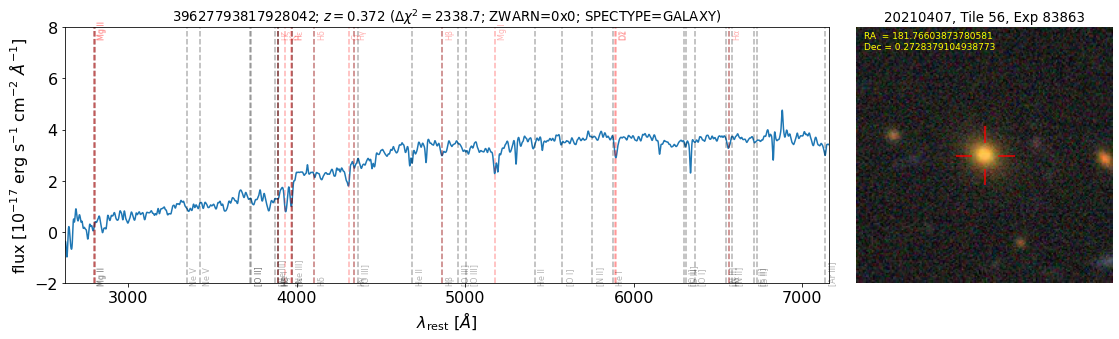

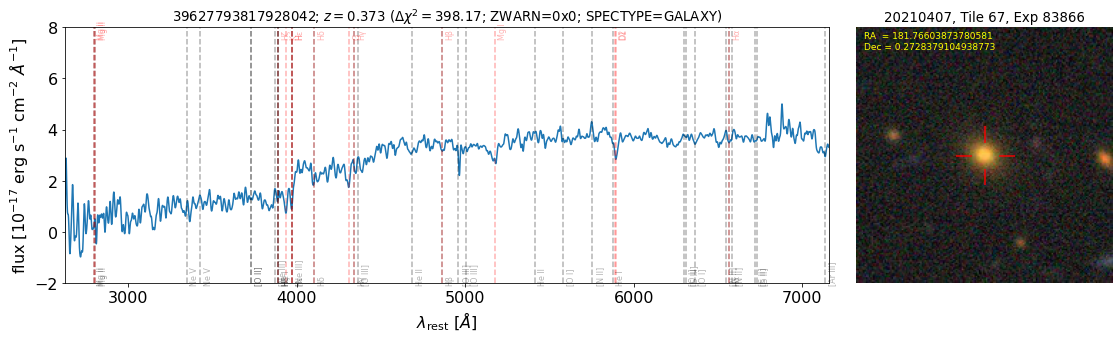

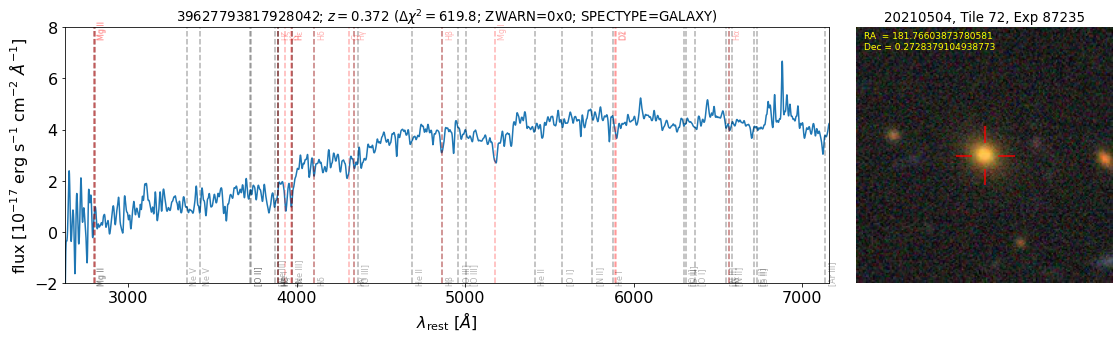

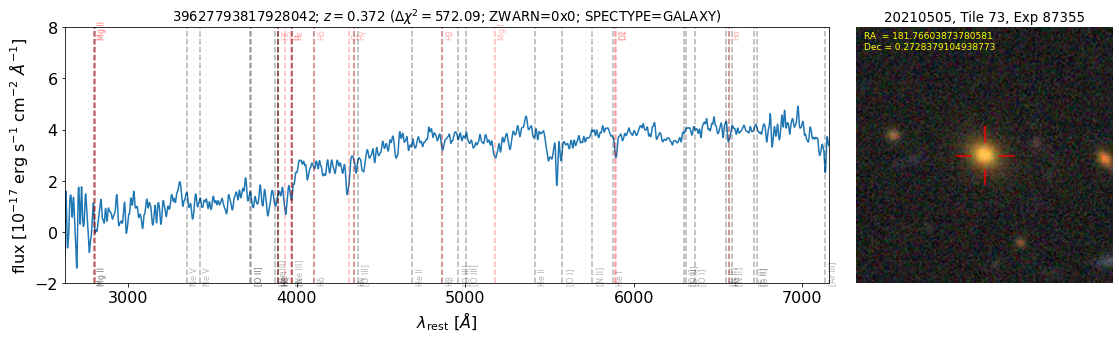

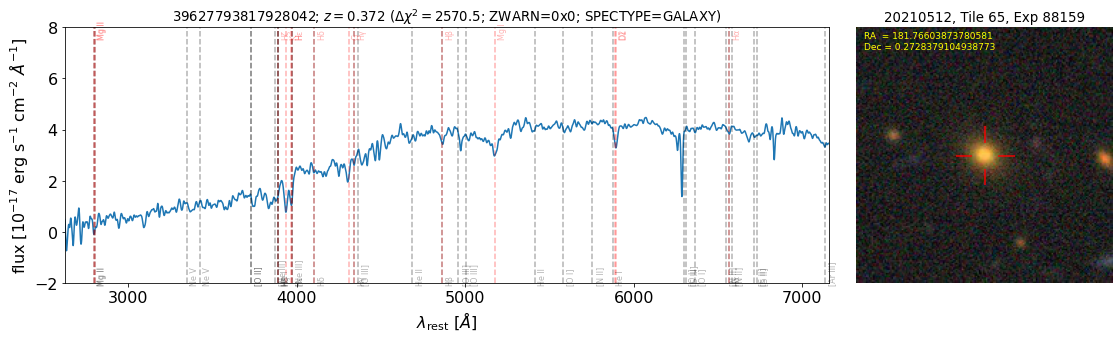

In [119]:
for i in range(toospec.num_spectra()):
    
    fig, axes = plt.subplots(1,2, figsize=(16,5), gridspec_kw={'width_ratios':[3,1.1]},
                             tight_layout=True)
    
    # Plot the spectra.
    ax = axes[0]
    
    fmin, fmax = 1e99, -1e99
#     for band in 'brz':
#         smoothed = gaussian_filter1d(toospec.flux[band][i], 5)
#         fmin = np.minimum(fmin, np.min(smoothed))
#         fmax = np.maximum(fmax, np.max(smoothed))
#         ax.plot(toospec.wave[band], smoothed)

    coadded_flux = coadd_cameras(toospec[i])
    
    zbest = toospec.extra_catalog[i]
    z = zbest['Z']
    dchi2 = zbest['DELTACHI2']
    zwarn = zbest['ZWARN']
    sptype = zbest['SPECTYPE']
    print(dchi2, zwarn)

    smoothed = gaussian_filter1d(coadded_flux.flux['brz'][0], 7)
#     fmin = np.minimum(fmin, np.min(smoothed))
#     fmax = np.maximum(fmax, np.max(smoothed))
#     print(fmin, fmax)
    fmin, fmax = -2, 8
    restwave = coadded_flux.wave['brz']/(1+z)
    ax.plot(restwave, smoothed)
    
    for eline in emi_lines:
        wl = eline['lambda']#*(1 + z)
        if wl > restwave[0] and wl < restwave[-1]:
            ax.axvline(wl, ls='--', color='k', alpha=0.3)
            ax.text(wl+20, fmin, eline['name'], fontsize=8, rotation=90, alpha=0.3)

    for aline in abs_lines:
        wl = aline['lambda']#*(1 + z)
        if wl > restwave[0] and wl < restwave[-1]:
            ax.axvline(wl, ls='--', color='r', alpha=0.3)
            ax.text(wl+20, 0.95*fmax, aline['name'], color='r', fontsize=8, rotation=90, alpha=0.3)

    ax.set(xlabel=r'$\lambda_{\mathrm{rest}}$ [$\AA$]',
           xlim=(restwave[0], restwave[-1]),
           ylabel=r'flux [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]',
           ylim=(fmin, fmax),
           title=r'{}; $z={:.3f}$ ($\Delta\chi^2={:.5g}$; ZWARN=0x{:x}; SPECTYPE={:s})'.format(toospec.fibermap[i]['TARGETID'], z, dchi2, zwarn, sptype.decode('utf-8')),
          )
    
    # Plot the image cutout.
    ax = axes[1]
    
    obj = toospec.fibermap[i]
    obj_exp = toospec.exp_fibermap[i]
    img_file = get_cutout(obj['TARGETID'], obj['TARGET_RA'], obj['TARGET_DEC'])
    img = mpl.image.imread(img_file)

    ax.imshow(img)

    x1, x2, x3, x4 = [90, 90], [70, 80], [90, 90], [100,110]
    y1, y2, y3, y4 = [70, 80], [90, 90], [100,110], [90,90]
    ax.plot(x1, y1, x2, y2, x3, y3, x4, y4, color='r', linewidth=2, alpha=0.7)
    ax.text(5,15, '{:3s} = {}\n{:3s} = {}'.format('RA', obj['TARGET_RA'], 'Dec', obj['TARGET_DEC']), color='yellow', fontsize=9)
    ax.set(aspect='equal',
           title='{}, Tile {}, Exp {}'.format(obj_exp['NIGHT'], obj['TILEID'], obj_exp['EXPID']))
    ax.axis('off')
    
    fig.savefig('spec_cutout_{}_{}_{:06d}_{:06d}.png'.format(obj['TARGETID'], obj_exp['NIGHT'], obj['TILEID'], obj_exp['EXPID']), dpi=100)
    
#     # Clean up
#     fig.clear()
#     plt.close(fig)

2338.7323203124106 0
398.17458318639547 0
619.8014330789447 0
572.0868395138532 0
2570.478048339486 0


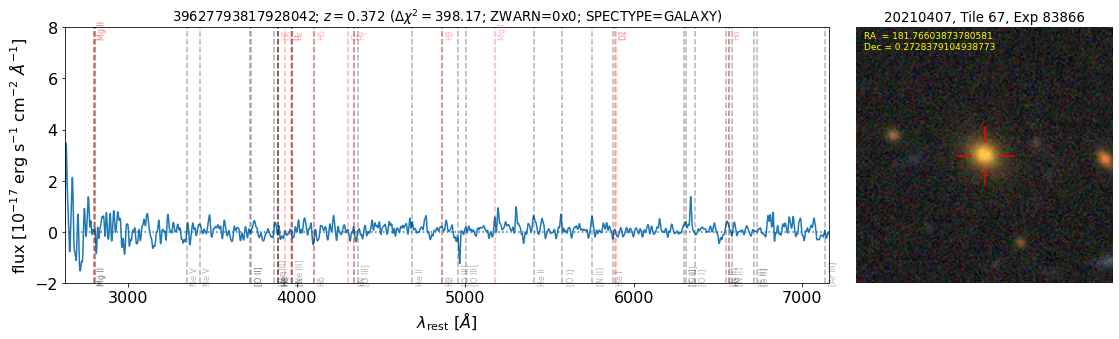

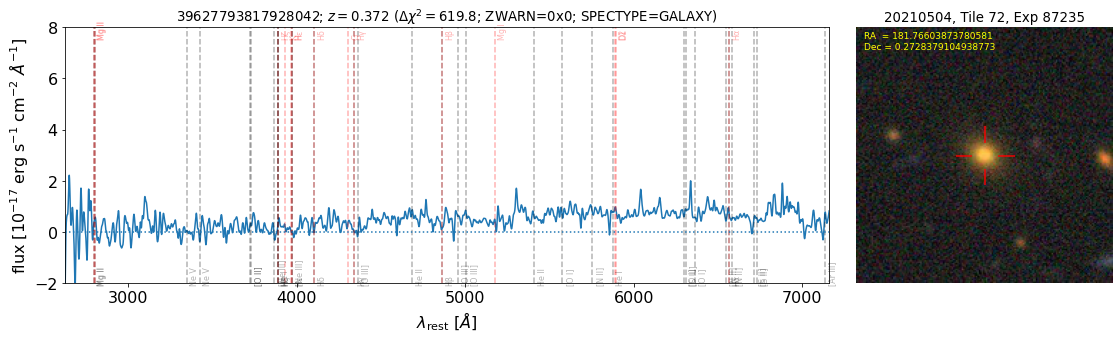

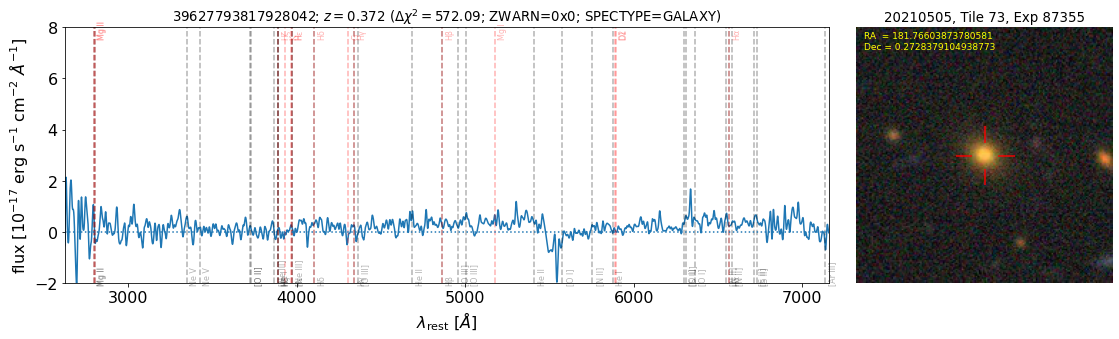

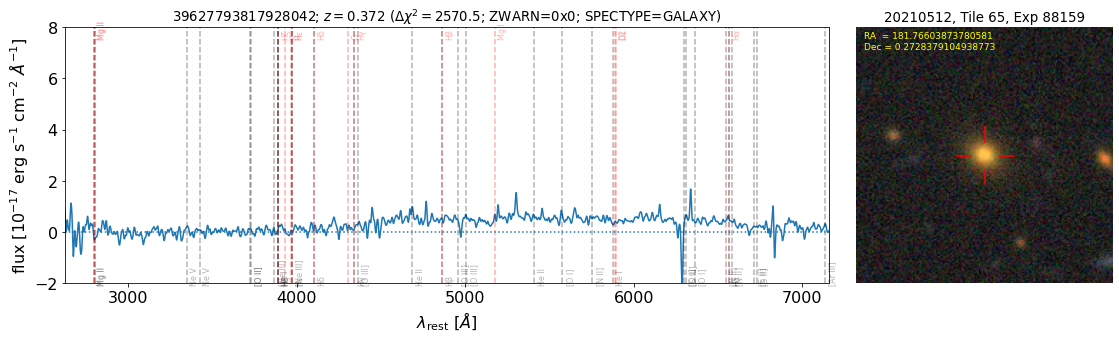

In [123]:
firstflux = None

for i in range(toospec.num_spectra()):
    
    fig, axes = plt.subplots(1,2, figsize=(16,5), gridspec_kw={'width_ratios':[3,1.1]},
                             tight_layout=True)
    
    # Plot the spectra.
    ax = axes[0]
    
    fmin, fmax = 1e99, -1e99
#     for band in 'brz':
#         smoothed = gaussian_filter1d(toospec.flux[band][i], 5)
#         fmin = np.minimum(fmin, np.min(smoothed))
#         fmax = np.maximum(fmax, np.max(smoothed))
#         ax.plot(toospec.wave[band], smoothed)

    coadded_flux = coadd_cameras(toospec[i])
    
    zbest = toospec.extra_catalog[i]
#     z = zbest['Z']
    z = 0.372
    dchi2 = zbest['DELTACHI2']
    zwarn = zbest['ZWARN']
    sptype = zbest['SPECTYPE']
    print(dchi2, zwarn)

    smoothed = gaussian_filter1d(coadded_flux.flux['brz'][0], 7)
#     fmin = np.minimum(fmin, np.min(smoothed))
#     fmax = np.maximum(fmax, np.max(smoothed))
#     print(fmin, fmax)
    fmin, fmax = -2, 8
    restwave = coadded_flux.wave['brz']/(1+z)
    
    if firstflux is None:
        firstflux = smoothed
        fig.clear()
        plt.close(fig)
        continue
    
    ax.plot(restwave, smoothed - firstflux)
    
    for eline in emi_lines:
        wl = eline['lambda']#*(1 + z)
        if wl > restwave[0] and wl < restwave[-1]:
            ax.axvline(wl, ls='--', color='k', alpha=0.3)
            ax.text(wl+20, fmin, eline['name'], fontsize=8, rotation=90, alpha=0.3)

    for aline in abs_lines:
        wl = aline['lambda']#*(1 + z)
        if wl > restwave[0] and wl < restwave[-1]:
            ax.axvline(wl, ls='--', color='r', alpha=0.3)
            ax.text(wl+20, 0.95*fmax, aline['name'], color='r', fontsize=8, rotation=90, alpha=0.3)

    ax.set(xlabel=r'$\lambda_{\mathrm{rest}}$ [$\AA$]',
           xlim=(restwave[0], restwave[-1]),
           ylabel=r'flux [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]',
           ylim=(fmin, fmax),
           title=r'{}; $z={:.3f}$ ($\Delta\chi^2={:.5g}$; ZWARN=0x{:x}; SPECTYPE={:s})'.format(toospec.fibermap[i]['TARGETID'], z, dchi2, zwarn, sptype.decode('utf-8')),
          )
    
    ax.axhline(0, ls=':')
    
    # Plot the image cutout.
    ax = axes[1]
    
    obj = toospec.fibermap[i]
    obj_exp = toospec.exp_fibermap[i]
    img_file = get_cutout(obj['TARGETID'], obj['TARGET_RA'], obj['TARGET_DEC'])
    img = mpl.image.imread(img_file)

    ax.imshow(img)

    x1, x2, x3, x4 = [90, 90], [70, 80], [90, 90], [100,110]
    y1, y2, y3, y4 = [70, 80], [90, 90], [100,110], [90,90]
    ax.plot(x1, y1, x2, y2, x3, y3, x4, y4, color='r', linewidth=2, alpha=0.7)
    ax.text(5,15, '{:3s} = {}\n{:3s} = {}'.format('RA', obj['TARGET_RA'], 'Dec', obj['TARGET_DEC']), color='yellow', fontsize=9)
    ax.set(aspect='equal',
           title='{}, Tile {}, Exp {}'.format(obj_exp['NIGHT'], obj['TILEID'], obj_exp['EXPID']))
    ax.axis('off')
    
    fig.savefig('diffspec_cutout_{}_{}_{:06d}_{:06d}.png'.format(obj['TARGETID'], obj_exp['NIGHT'], obj['TILEID'], obj_exp['EXPID']), dpi=100)

In [28]:
too_targets.write('desi_too.txt', format='ascii.commented_header', overwrite=True)

In [29]:
write_spectra('too_desi_dailyspectra.fits', toospec)

INFO:spectra.py:154:write_spectra: iotime 1.456 sec to write too_desi_dailyspectra.fits at 2021-05-28T06:33:44.054476


'/global/u2/s/sybenzvi/desi/timedomain/db/too_desi_dailyspectra.fits'

In [31]:
toospec?

Type:        Spectra
String form: <desispec.spectra.Spectra object at 0x2aaade44d910>
File:        /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desispec/master/py/desispec/spectra.py
Docstring:  
Represents a grouping of spectra.

This class contains an "extended" fibermap that has information about
the night and exposure of each spectrum.  For each band, this class has 
the wavelength grid, flux, ivar, mask, and resolution arrays.

Parameters
----------
bands : :class:`list`
    List of strings used to identify the bands.
wave : :class:`dict`
    Dictionary of arrays specifying the wavelength grid.
flux : :class:`dict`
    Dictionary of arrays specifying the flux for each spectrum.
ivar : :class:`dict`
    Dictionary of arrays specifying the inverse variance.
mask : :class:`dict`, optional
    Dictionary of arrays specifying the bitmask.
resolution_data : :class:`dict`, optional
    Dictionary of arrays specifying the block diagonal resolution matrix.
    The o

In [43]:
np.savez('too_desi_dailyspectra.npz', bands=toospec.bands, wave=toospec.wave, flux=toospec.flux, ivar=toospec.ivar, fibermap=toospec.fibermap)

In [39]:
arrays = np.load('too_desi_dailyspectra.npz', allow_pickle=True)